<a href="https://colab.research.google.com/github/ridhsk/DeepFake-Detection/blob/main/models/XceptionNet/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
from mtcnn import MTCNN
from tqdm import tqdm

# Constants
FRAME_SKIP = 10  # Extract every 10th frame
IMG_SIZE = 299
FRAMES_PER_VIDEO = 10  # Number of frames to extract from each video

# Paths
DATA_DIR = "/content/drive/MyDrive/DeepFake Detection/FaceForensicsData"
REAL_VIDEOS = os.path.join(DATA_DIR, "original_sequences/youtube/c23/videos")
FAKE_VIDEOS = os.path.join(DATA_DIR, "manipulated_sequences/Deepfakes/c23/videos")

# Output dataset structure
OUTPUT_DIR = "/content/drive/MyDrive/DeepFake Detection/dataset_new_xceptionNet"
os.makedirs(os.path.join(OUTPUT_DIR, "real"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "fake"), exist_ok=True)

# Face extractor
detector = MTCNN()

def extract_faces_from_video(video_path, output_folder, label_prefix):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or saved_count >= FRAMES_PER_VIDEO:
            break
        if frame_count % FRAME_SKIP == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = detector.detect_faces(rgb)
            if faces:
                x, y, w, h = faces[0]['box']
                face = rgb[y:y+h, x:x+w]
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                filename = f"{label_prefix}_{saved_count}.jpg"
                save_path = os.path.join(output_folder, filename)
                cv2.imwrite(save_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
                saved_count += 1
        frame_count += 1
    cap.release()

# Process real videos
for video_file in tqdm(os.listdir(REAL_VIDEOS), desc="Processing Real Videos"):
    path = os.path.join(REAL_VIDEOS, video_file)
    extract_faces_from_video(path, os.path.join(OUTPUT_DIR, "real"), video_file.replace(".mp4", ""))

# Process fake videos
for video_file in tqdm(os.listdir(FAKE_VIDEOS), desc="Processing Fake Videos"):
    path = os.path.join(FAKE_VIDEOS, video_file)
    extract_faces_from_video(path, os.path.join(OUTPUT_DIR, "fake"), video_file.replace(".mp4", ""))


Processing Fake Videos: 100%|██████████| 500/500 [1:16:16<00:00,  9.15s/it]


In [ ]:
import os
import glob
import re
import numpy as np
import tensorflow as tf

# ✅ Enable eager execution globally (for debugging)
tf.config.run_functions_eagerly(True)

from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/dataset_new_xceptionNet"
CHECKPOINT_DIR = "/content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints"
FINAL_MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/64Batchsize/xception_deepfake_model_final.h5"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Constants
IMG_SIZE = 299
BATCH_SIZE = 16  # ✅ Reduced to avoid GPU OOM error
EPOCHS = 30
INITIAL_EPOCH = 0

# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['real', 'fake']
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['real', 'fake']
)

# Check for existing checkpoints
checkpoint_files = sorted(
    glob.glob(os.path.join(CHECKPOINT_DIR, 'xception_epoch_*.h5'))
)

if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"Resuming from checkpoint: {latest_checkpoint}")

    # Load model
    model = tf.keras.models.load_model(latest_checkpoint)

    # ✅ Re-compile model after loading
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Extract epoch number to resume from
    match = re.search(r'epoch_(\d+)', latest_checkpoint)
    if match:
        INITIAL_EPOCH = int(match.group(1))
else:
    print("No checkpoint found, building model from scratch...")

    # Base model
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    )

    for layer in base_model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

    # Custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'xception_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.h5'),
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    callbacks=callbacks
)

# Save final model
model.save(FINAL_MODEL_PATH)
print(f"✅ Model saved to: {FINAL_MODEL_PATH}")


Found 8000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
Resuming from checkpoint: /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_08_valacc_0.9390.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 9/30


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9910 - loss: 0.0170
Epoch 9: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_09_valacc_0.9525.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 1939s 4s/step - accuracy: 0.9910 - loss: 0.0170 - val_accuracy: 0.9525 - val_loss: 0.1633 - learning_rate: 1.0000e-05
Epoch 10/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9942 - loss: 0.0140
Epoch 10: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_10_valacc_0.9535.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 356s 712ms/step - accuracy: 0.9942 - loss: 0.0140 - val_accuracy: 0.9535 - val_loss: 0.1568 - learning_rate: 1.0000e-05
Epoch 11/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9936 - loss: 0.0138
Epoch 11: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_11_valacc_0.9520.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 354s 708ms/step - accuracy: 0.9936 - loss: 0.0138 - val_accuracy: 0.9520 - val_loss: 0.1717 - learning_rate: 1.0000e-05
Epoch 12/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9964 - loss: 0.0094
Epoch 12: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_12_valacc_0.9490.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
500/500 ━━━━━━━━━━━━━━━━━━━━ 355s 709ms/step - accuracy: 0.9963 - loss: 0.0094 - val_accuracy: 0.9490 - val_loss: 0.1698 - learning_rate: 1.0000e-05
Epoch 13/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9980 - loss: 0.0059
Epoch 13: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_13_valacc_0.9575.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 354s 707ms/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9575 - val_loss: 0.1662 - learning_rate: 2.0000e-06
Epoch 14/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9986 - loss: 0.0045
Epoch 14: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_14_valacc_0.9545.h5



Epoch 14: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
500/500 ━━━━━━━━━━━━━━━━━━━━ 383s 710ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9545 - val_loss: 0.1765 - learning_rate: 2.0000e-06
Epoch 15/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9991 - loss: 0.0037
Epoch 15: saving model to /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/4cp/checkpoints/xception_epoch_15_valacc_0.9575.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 370s 741ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9575 - val_loss: 0.1802 - learning_rate: 4.0000e-07
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


✅ Model saved to: /content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/64Batchsize/xception_deepfake_model_final.h5


Found 1999 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step

🔍 Evaluation Metrics:
Accuracy:  0.9525
Precision: 0.9363
Recall:    0.9710
F1 Score:  0.9533
ROC AUC:   0.9933


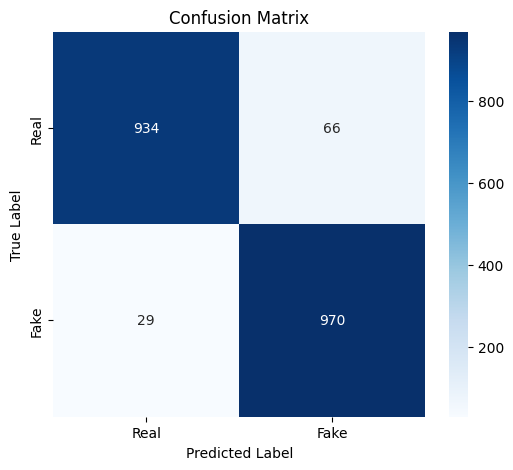

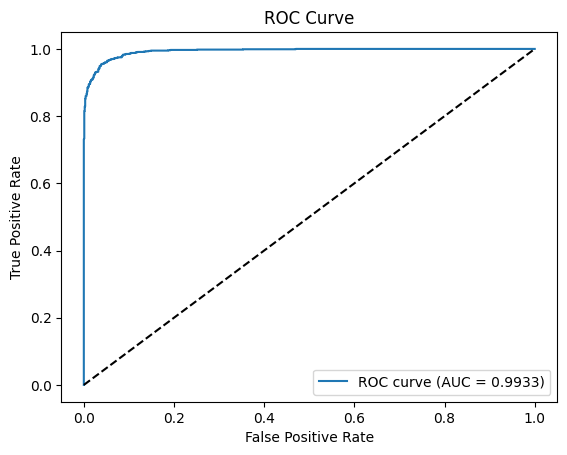

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/64Batchsize/xception_deepfake_model_final.h5"
# DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/dataset"
DATASET_DIR="/content/drive/MyDrive/DeepFake Detection/dataset_new_xceptionNet"
IMG_SIZE = 299
BATCH_SIZE = 32

# === Load Model ===
model = load_model(MODEL_PATH)

# === Prepare Validation Data Generator ===
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['real', 'fake']  # real=0, fake=1
)

# === Predict ===
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# === Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)

print("\n🔍 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (0 = all, 1 = info, 2 = warning, 3 = error)

import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
import tensorflow as tf

# Disable TensorFlow retracing warning
tf.get_logger().setLevel('ERROR')

# Load model
model = load_model("/content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/64Batchsize/xception_deepfake_model_final.h5")
IMG_SIZE = 299
FRAME_SKIP = 10

# Load video
video_path = "/content/drive/MyDrive/DeepFake Detection/dataset10/fake/022_489.mp4"
cap = cv2.VideoCapture(video_path)

# Face detector
detector = MTCNN()
predictions = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if frame_id % FRAME_SKIP != 0:
        continue

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(rgb)

    if faces:
        x, y, w, h = faces[0]['box']
        face = rgb[y:y+h, x:x+w]
        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        face = face / 255.0
        face = np.expand_dims(face, axis=0)

        pred = model.predict(face, verbose=0)[0][0]  # Suppress predict output
        predictions.append(pred)

cap.release()

# Final decision: average prediction
if len(predictions) == 0:
    print("No faces detected.")
else:
    avg_pred = np.mean(predictions)
    print(f"Average Prediction: {avg_pred:.4f}")
    print("Final Classification:", "DeepFake" if avg_pred > 0.5 else "Real")


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Average Prediction: 0.9625
Final Classification: DeepFake


Found 1999 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 529s 8s/step

🔍 Evaluation Metrics:
Accuracy:         0.9525
Precision:        0.9363
Recall:           0.9710
F1 Score:         0.9533
ROC AUC:          0.9933
AUPRC:            0.9937
Log Loss:         0.1601
MCC:              0.9056
EER:              0.0450 (Threshold: 0.7898)
False Positive Rate: 0.0660
False Negative Rate: 0.0290


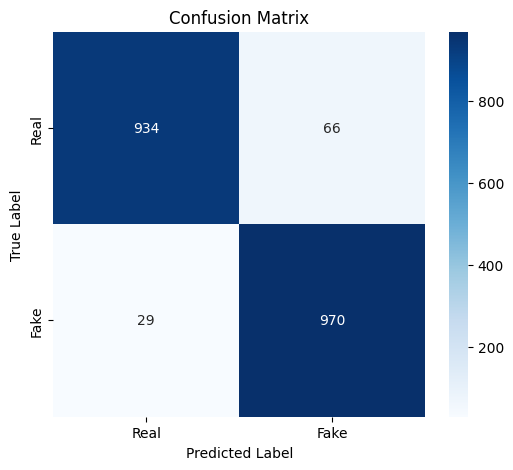

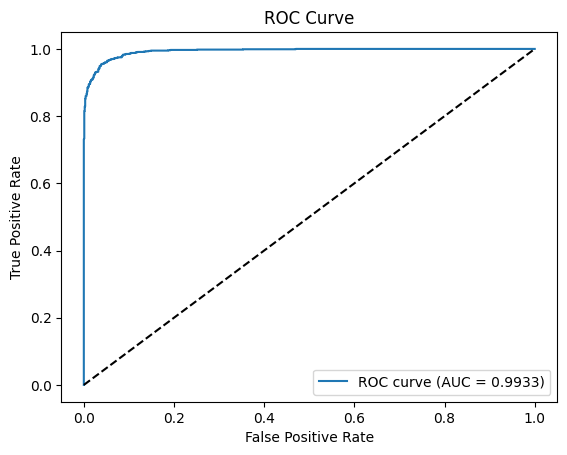

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, log_loss, matthews_corrcoef
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/XceptionNet/64Batchsize/xception_deepfake_model_final.h5"
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/dataset_new_xceptionNet"
IMG_SIZE = 299
BATCH_SIZE = 32

# === Load Model ===
model = load_model(MODEL_PATH)

# === Prepare Validation Data Generator ===
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['real', 'fake']  # real=0, fake=1
)

# === Predict ===
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# === Basic Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)

# === Extra Metrics ===
# AUPRC
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
auprc = auc(recall_vals, precision_vals)

# Log Loss
logloss = log_loss(y_true, y_pred_prob)

# MCC
mcc = matthews_corrcoef(y_true, y_pred)

# Equal Error Rate (EER)
fpr_vals, tpr_vals, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr_vals
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr_vals))]
eer = fpr_vals[np.nanargmin(np.absolute(fnr - fpr_vals))]

# FPR and FNR
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr_value = fp / (fp + tn)
fnr_value = fn / (fn + tp)

# === Print Metrics ===
print("\n🔍 Evaluation Metrics:")
print(f"Accuracy:         {acc:.4f}")
print(f"Precision:        {prec:.4f}")
print(f"Recall:           {rec:.4f}")
print(f"F1 Score:         {f1:.4f}")
print(f"ROC AUC:          {auc_roc:.4f}")
print(f"AUPRC:            {auprc:.4f}")
print(f"Log Loss:         {logloss:.4f}")
print(f"MCC:              {mcc:.4f}")
print(f"EER:              {eer:.4f} (Threshold: {eer_threshold:.4f})")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"False Negative Rate: {fnr_value:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# === ROC Curve ===
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"ROC curve (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
